In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from joblib import Parallel, delayed

np.set_printoptions(suppress=True, precision=6)
pd.set_option('display.float_format', '{:.6f}'.format)

2023-08-14 16:36:21.419803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 16:36:22.111553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("data/otu_table_example.csv", index_col="Unnamed: 0").T

In [3]:
print(df.head())

             1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8        0        0        0        0        0        0        0   
E000823.2.6        0        0        0        0        0        0        0   
E000823.4.0        0        0        0        0        0        0        0   
E000823.5.0        0        0        0        0        0        0        0   
E000823.5.7        0        0        0        0        0        0        0   

             4327628  326749   183857   ...  317924   4294457  2655741  \
E000823.1.8        0        0        0  ...        0        0        0   
E000823.2.6        0        0        0  ...        0        0        0   
E000823.4.0        0        0        0  ...        0        0        0   
E000823.5.0        0        0        0  ...        0        0        0   
E000823.5.7        0        0        0  ...        0        0        0   

             858535   186092   299820   225846   4306049  366846   1124370  
E000823.1

In [4]:
# get rid of features that are way too sparse
zero_values_percentage_cutoff = .8

zero_counts = pd.Series([sum(df[col] == 0) for col in df.columns], index=df.columns)
zero_pcts = zero_counts / len(df)
populated_feats = zero_pcts[zero_pcts < zero_values_percentage_cutoff].index
df = df[populated_feats]

In [5]:
df

,189592,183857,4343580,177319,194104,362389,1142029,199301,659361,364179,...,364563,583117,179423,823634,356360,365385,580008,296945,267718,354850
E000823.1.8,0,0,2,0,0,0,0,0,0,0,...,0,65,0,0,0,1,0,0,0,7
E000823.2.6,0,0,1,0,0,0,2,0,0,4,...,0,90,0,0,0,1,0,0,0,2
E000823.4.0,0,0,0,0,0,0,0,0,0,4,...,0,170,0,0,0,4,0,0,0,4
E000823.5.0,0,0,0,0,0,0,0,0,0,0,...,0,85,0,0,0,2,0,0,0,0
E000823.5.7,0,0,0,0,0,0,1,0,0,5,...,0,55,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,1,0,4,13,6,1,0,27,101,2117,...,1,5003,0,8,0,1,446,0,5,7
E014086.32.4,0,0,0,44,16,0,0,50,33,2520,...,7,10760,2,10,4,0,851,0,3,50
E014086.33.5,0,0,3,11,11,0,0,39,3,2447,...,2,8449,0,0,3,0,664,0,3,46
E014086.34.4,1,0,1,9,9,0,0,20,20,1402,...,2,4769,0,0,1,0,180,0,3,28


In [6]:
def forward_rolling_average(series, window_size):
    
    original_idxs = series.index
    
    series = series.reset_index(drop=True)
    
    for idx in range(len(series) - window_size):
       
        next_vals = series[idx+1:idx+window_size+1]
        
        #print(idx, next_vals.tolist())
        
        series[idx] = next_vals.mean()
    
    series.index = original_idxs
    
    series = series.iloc[:-window_size]
            
    return series
    

In [9]:
window_size = 3
sequence = pd.Series([0,1,2,3,4,5,6,7,8,9,10])

forward_rolling_average(sequence, window_size)

0    2
1    3
2    4
3    5
4    6
5    7
6    8
7    9
dtype: int64

In [7]:
#def smooth_it_out(df, rolling_window=5):
#    # Define the window size for the rolling average
#    window_size = 5
#    
#    # Apply rolling mean to numeric columns
#    df = df.shift(-window_size + 1).rolling(window=window_size).mean()
#    
#    return df

In [8]:
def smooth_it_out(df, window_size=5, n_jobs=32):
    
    smooth_cols = Parallel(n_jobs=-n_jobs)(delayed(forward_rolling_average)(df[col], window_size) for col in df.columns)
    
    for idx, col in enumerate(df.columns):
        df[col] = smooth_cols[idx]
    
    return df

In [10]:
def feature_wise_scaling(df):
    for col in df.columns:
        _min_ = df[col].min()
        _max_ = df[col].max()
        
        df[col] = (df[col] - _min_) / (_max_ - _min_)
        
    return df      

In [11]:
def preprocess(feats_df, seq_length):
    num_features = len(feats_df.columns)
    
    X_sequences = []
    y_targets = []
    
    for i in range(len(feats_df) - seq_length):
        X_sequences.append(feats_df.iloc[i:i+seq_length])
        y_targets.append(feats_df.iloc[i+seq_length])
    
    X_sequences = np.array(X_sequences)
    y_targets = np.array(y_targets)
    
    X_sequences = X_sequences.reshape(-1, seq_length, num_features)
    
    return X_sequences, y_targets

In [12]:
def mae_ignore_zeros(y_true, y_pred, false_positives_penalty_factor=0.5):
    
    # Find indices where y_true is not zero
    non_zero_indices = tf.where(tf.not_equal(y_true, 0))
    
    # Gather the non-zero elements from y_true and y_pred using the indices
    y_true_non_zero = tf.gather_nd(y_true, non_zero_indices)
    y_pred_non_zero = tf.gather_nd(y_pred, non_zero_indices)
    
    y_true_non_zero = tf.cast(y_true_non_zero, tf.float64)
    y_pred_non_zero = tf.cast(y_pred_non_zero, tf.float64)
    
    # Calculate MAE on the non-zero elements
    mae_non_zero = tf.reduce_mean(tf.abs(y_pred_non_zero - y_true_non_zero))
    
    # Find indices where y_true is zero 
    zero_indices = tf.where(tf.equal(y_true, 0))
    
    # Gather the corresponding y_pred values
    y_pred_zero = tf.gather_nd(y_pred, zero_indices)
    
    y_pred_zero = tf.cast(y_pred_zero, tf.float64)
    
    # Calculate the average of false positives
    false_positives_avg = tf.reduce_mean(y_pred_zero)
    
    # Combine the MAE on non-zero elements with the average of false positives
    mae_ignore_zeros = mae_non_zero + (false_positives_avg * false_positives_penalty_factor)
    
    return mae_ignore_zeros

In [13]:
y_true = [0,0,10]
y_pred = [0,0,0]

keras.losses.mae(y_true, y_pred)

2023-08-14 16:36:23.991916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 16:36:24.009858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-14 16:36:24.010104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [14]:
mae_ignore_zeros(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=10.0>

In [15]:
df = smooth_it_out(df=df, window_size=5)
df

,189592,183857,4343580,177319,194104,362389,1142029,199301,659361,364179,...,364563,583117,179423,823634,356360,365385,580008,296945,267718,354850
E000823.1.8,0.000000,0.200000,0.200000,0.000000,0.000000,0.400000,1.400000,0.000000,34.800000,3.200000,...,0.000000,91.000000,0.800000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.200000
E000823.2.6,0.000000,0.200000,0.000000,0.000000,0.000000,0.400000,3.200000,0.000000,34.800000,3.000000,...,0.000000,290.000000,0.800000,0.000000,0.000000,1.800000,0.000000,0.000000,0.000000,0.800000
E000823.4.0,0.000000,0.400000,0.200000,0.000000,0.000000,0.400000,3.400000,0.000000,34.800000,2.400000,...,0.000000,270.600000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
E000823.5.0,0.200000,0.600000,0.200000,2.600000,8.400000,1.000000,3.400000,0.600000,34.800000,2.400000,...,0.000000,735.800000,1.400000,0.000000,0.000000,13.800000,0.000000,0.000000,0.000000,0.800000
E000823.5.7,0.200000,0.600000,0.200000,3.600000,11.000000,1.600000,3.200000,6.000000,34.800000,1.600000,...,0.000000,1086.400000,1.400000,0.200000,0.400000,45.600000,0.400000,0.000000,0.000000,1.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.32.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.33.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.34.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df = feature_wise_scaling(df)
df

,189592,183857,4343580,177319,194104,362389,1142029,199301,659361,364179,...,364563,583117,179423,823634,356360,365385,580008,296945,267718,354850
E000823.1.8,0.000000,0.055556,0.028571,0.000000,0.000000,0.048780,0.036842,0.000000,0.052888,0.000273,...,0.000000,0.010298,0.038835,0.000000,0.000000,0.000848,0.000000,0.000000,0.000000,0.019934
E000823.2.6,0.000000,0.055556,0.000000,0.000000,0.000000,0.048780,0.084211,0.000000,0.052888,0.000256,...,0.000000,0.032819,0.038835,0.000000,0.000000,0.000763,0.000000,0.000000,0.000000,0.013289
E000823.4.0,0.000000,0.111111,0.028571,0.000000,0.000000,0.048780,0.089474,0.000000,0.052888,0.000204,...,0.000000,0.030623,0.048544,0.000000,0.000000,0.000424,0.000000,0.000000,0.000000,0.000000
E000823.5.0,0.002538,0.166667,0.028571,0.151163,0.330709,0.121951,0.089474,0.007335,0.052888,0.000204,...,0.000000,0.083269,0.067961,0.000000,0.000000,0.005852,0.000000,0.000000,0.000000,0.013289
E000823.5.7,0.002538,0.166667,0.028571,0.209302,0.433071,0.195122,0.084211,0.073350,0.052888,0.000136,...,0.000000,0.122946,0.067961,0.005618,0.055556,0.019337,0.000142,0.000000,0.000000,0.019934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.32.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.33.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.34.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df.describe()

,189592,183857,4343580,177319,194104,362389,1142029,199301,659361,364179,...,364563,583117,179423,823634,356360,365385,580008,296945,267718,354850
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,0.073816,0.098514,0.182669,0.085069,0.135522,0.190490,0.055498,0.114426,0.089148,0.031999,...,0.098647,0.155169,0.053963,0.092675,0.101421,0.050918,0.064797,0.050222,0.105341,0.234973
std,0.137924,0.126745,0.167193,0.149385,0.219066,0.196389,0.111797,0.194425,0.132352,0.119965,...,0.139653,0.188499,0.105903,0.162989,0.138458,0.135823,0.130838,0.119696,0.172277,0.214800
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.057143,0.000000,0.000000,0.024390,0.005263,0.002445,0.001520,0.000102,...,0.000000,0.007628,0.000000,0.000000,0.000000,0.000085,0.000000,0.000000,0.000000,0.053156
50%,0.010152,0.055556,0.142857,0.023256,0.015748,0.146341,0.021053,0.036675,0.032523,0.000307,...,0.053571,0.094394,0.019417,0.016854,0.055556,0.002460,0.000213,0.000000,0.030303,0.171096
75%,0.076142,0.166667,0.257143,0.104651,0.204724,0.292683,0.068421,0.132029,0.139894,0.004216,...,0.133929,0.216355,0.067961,0.123596,0.138889,0.042299,0.082367,0.038005,0.138258,0.375415
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
seq_length = 50
cutoff = 411

X_sequences, y_targets = preprocess(feats_df=df, seq_length=seq_length)

In [19]:
X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 521
Total sequences: 471
Train sequences: 411
Test sequences: 60


In [20]:
n_feats = len(df.columns)

In [50]:
reg = 1e-12
loss=mae_ignore_zeros

model = Sequential()
model.add(keras.Input(shape=(seq_length,n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(1024, activation="relu", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1024)              7483392   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_5 (Dense)             (None, 802)               822050    
                                                                 
Total params: 9355042 (35.69 MB)
Trainable params: 9355042 (35.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
model.fit(x=X_sequences_train, y=y_targets_train, validation_split=0.1, epochs=10)

Epoch 1/10
12/12 [==============================] - 2s 70ms/step - loss: 14.6263 - mae: 0.0998 - mape: 4660857.0000 - val_loss: 9.5457 - val_mae: 0.0894 - val_mape: 3371848.0000
Epoch 2/10
12/12 [==============================] - 1s 55ms/step - loss: 6.8667 - mae: 0.0900 - mape: 4399377.5000 - val_loss: 4.1469 - val_mae: 0.0866 - val_mape: 3918928.5000
Epoch 3/10
12/12 [==============================] - 1s 55ms/step - loss: 2.8542 - mae: 0.0856 - mape: 4444240.0000 - val_loss: 1.6122 - val_mae: 0.0855 - val_mape: 7013250.5000
Epoch 4/10
12/12 [==============================] - 1s 55ms/step - loss: 1.0775 - mae: 0.0834 - mape: 4543670.0000 - val_loss: 0.5928 - val_mae: 0.0839 - val_mape: 5533200.5000
Epoch 5/10
12/12 [==============================] - 1s 55ms/step - loss: 0.4064 - mae: 0.0820 - mape: 4555780.0000 - val_loss: 0.2530 - val_mae: 0.0862 - val_mape: 6051671.0000
Epoch 6/10
12/12 [==============================] - 1s 54ms/step - loss: 0.1937 - mae: 0.0810 - mape: 4388127.0000

In [52]:
y_pred = model.predict(X_sequences_test)

2/2 [==============================] - 0s 10ms/step


In [53]:
y_test_df = pd.DataFrame(y_targets_test)
y_pred_df = pd.DataFrame(y_pred)

In [54]:
y_test_df

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,800,801
0,0.022843,0.111111,0.028571,0.000000,0.000000,0.219512,0.031579,0.623472,0.019149,0.012742,...,0.178571,0.222715,0.077670,0.106742,0.222222,0.000000,0.247618,0.000000,0.151515,0.235880
1,0.022843,0.111111,0.028571,0.000000,0.000000,0.219512,0.021053,0.613692,0.012158,0.014207,...,0.178571,0.255036,0.077670,0.095506,0.222222,0.000000,0.216683,0.000000,0.234848,0.481728
2,0.025381,0.000000,0.000000,0.000000,0.023622,0.024390,0.015789,0.168704,0.008207,0.010511,...,0.035714,0.142139,0.009709,0.033708,0.138889,0.000000,0.109017,0.000000,0.181818,0.385382
3,0.022843,0.055556,0.000000,0.000000,0.023622,0.170732,0.015789,0.166259,0.008207,0.004054,...,0.026786,0.089946,0.019417,0.011236,0.083333,0.000594,0.082847,0.000000,0.181818,0.338870
4,0.002538,0.055556,0.000000,0.000000,0.023622,0.170732,0.005263,0.031785,0.001520,0.004940,...,0.000000,0.089652,0.009709,0.011236,0.000000,0.000594,0.013512,0.000000,0.083333,0.335548
5,0.002538,0.055556,0.000000,0.000000,0.023622,0.170732,0.031579,0.031785,0.001520,0.007478,...,0.000000,0.100833,0.009709,0.011236,0.000000,0.000678,0.013512,0.000000,0.083333,0.335548
6,0.002538,0.055556,0.000000,0.081395,0.023622,0.170732,0.073684,0.031785,0.000608,0.006712,...,0.000000,0.037753,0.009709,0.011236,0.000000,0.000763,0.010454,0.000000,0.000000,0.049834
7,0.000000,0.055556,0.000000,0.081395,0.000000,0.170732,0.094737,0.031785,0.000000,0.006184,...,0.000000,0.070708,0.009709,0.000000,0.000000,0.000763,0.000000,0.066508,0.000000,0.003322
8,0.065990,0.000000,0.000000,0.081395,0.000000,0.000000,0.110526,0.244499,0.000000,0.006490,...,0.196429,0.127246,0.000000,0.000000,0.111111,0.000170,0.000000,0.168646,0.000000,0.000000
9,0.124365,0.000000,0.000000,0.081395,0.000000,0.121951,0.136842,0.606357,0.000000,0.016166,...,0.258929,0.189444,0.048544,0.000000,0.138889,0.000170,0.000000,0.211401,0.000000,0.000000


In [55]:
y_pred_df

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,800,801
0,0.000000,0.061085,0.173099,0.000000,0.214410,0.174460,0.030036,0.055354,0.005209,0.000000,...,0.136746,0.133979,0.007763,0.184951,0.084874,0.000000,0.000000,0.000000,0.073418,0.209234
1,0.000000,0.052556,0.159411,0.000000,0.198518,0.152888,0.028529,0.055679,0.000000,0.000000,...,0.116889,0.112770,0.006897,0.162819,0.086007,0.000000,0.000000,0.000000,0.073422,0.196742
2,0.000000,0.045366,0.163988,0.000000,0.227701,0.145964,0.031830,0.068944,0.000000,0.000000,...,0.118102,0.123693,0.000000,0.184464,0.095192,0.000000,0.000000,0.000000,0.091138,0.196370
3,0.000000,0.029299,0.108564,0.000000,0.101811,0.084066,0.028950,0.026260,0.009133,0.000000,...,0.068750,0.105790,0.001728,0.082231,0.039836,0.000000,0.000000,0.000000,0.028938,0.141539
4,0.000000,0.031424,0.111925,0.000000,0.074266,0.083858,0.036243,0.010996,0.010820,0.000000,...,0.065248,0.099139,0.006466,0.067323,0.023835,0.000000,0.000000,0.000000,0.012264,0.135844
5,0.000000,0.026395,0.103280,0.000000,0.036423,0.072584,0.043564,0.000000,0.016956,0.000000,...,0.059794,0.108663,0.007211,0.044283,0.001416,0.000000,0.000000,0.000000,0.000000,0.125855
6,0.000000,0.027117,0.104594,0.000000,0.009647,0.073234,0.049356,0.000000,0.022187,0.000000,...,0.059437,0.108815,0.011296,0.028337,0.000000,0.000000,0.000000,0.000000,0.000000,0.126874
7,0.000000,0.020213,0.092429,0.000000,0.000000,0.057149,0.056873,0.000000,0.016870,0.000000,...,0.041988,0.090919,0.015835,0.001694,0.000000,0.000000,0.000000,0.000000,0.000000,0.112808
8,0.000000,0.014426,0.080920,0.000000,0.000000,0.045163,0.061705,0.000000,0.009937,0.000000,...,0.027347,0.077182,0.018922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.099080
9,0.000000,0.021444,0.084991,0.000000,0.000000,0.058370,0.052024,0.000000,0.017681,0.000000,...,0.032997,0.076974,0.020598,0.000370,0.000000,0.000000,0.000000,0.000000,0.000000,0.103750


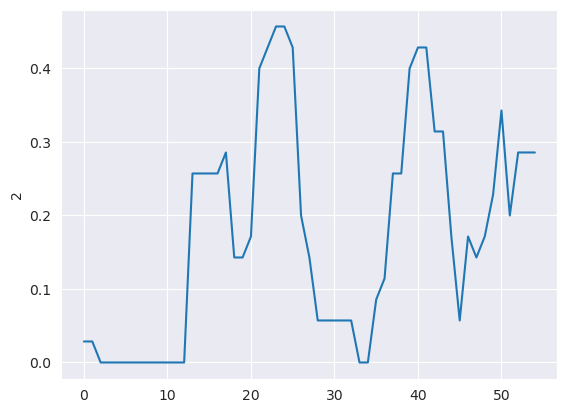

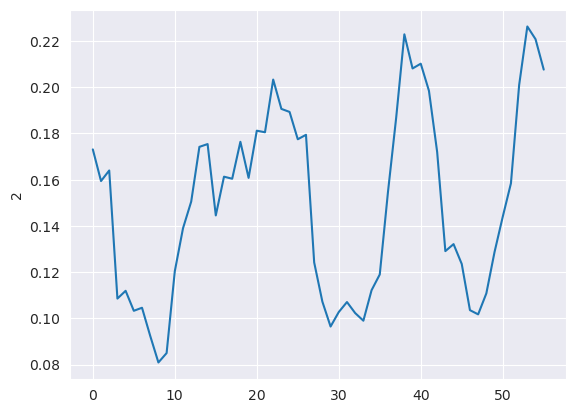

In [58]:
target_taxa = 2

sns.lineplot(y_test_df[target_taxa])
plt.show()

sns.lineplot(y_pred_df[target_taxa])
plt.show()

In [37]:
def calculate_errors(y_pred_df, y_test_df):
    
    errors_df = []
    for col in y_pred_df.columns:
        errors = abs((y_test_df[col] - y_pred_df[col] ) / (y_test_df[col] + 1e-10))
        errors_df.append(errors)
        
    errors_df = pd.concat(errors_df, axis=1)
    
    return errors_df

In [29]:
errors_df = calculate_errors(y_pred_df, y_test_df)
errors_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,800,801
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.872727,0.436364,208307152.241704,14255207.541271,0.745455,138517288.115715,0.672727,0.981818,50428089.701561,1.000000,...,62850602.031063,115.079641,89104805.210122,0.727273,0.854545,0.763636,0.781818,0.472727,0.727273,26640666.115484
std,0.336350,0.500505,417193428.710038,45057858.840776,0.439620,284576768.957972,0.473542,0.134840,117412935.410429,0.000000,...,138234901.149572,411.517099,156273399.065626,0.449467,0.355808,0.428764,0.416818,0.503857,0.449467,138906757.554751
min,0.000000,0.000000,0.013648,0.000000,0.000000,0.002074,0.000000,0.000000,0.035230,1.000000,...,0.095782,0.026056,0.084857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027858
25%,1.000000,0.000000,0.377729,0.857105,0.500000,0.315011,0.000000,1.000000,0.649007,1.000000,...,0.350331,0.418961,0.587073,0.000000,1.000000,0.999999,0.999999,0.000000,0.000000,0.483225
50%,1.000000,0.000000,0.570800,0.973462,1.000000,0.611033,1.000000,1.000000,13.268141,1.000000,...,0.750341,0.607747,1.085245,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.754487
75%,1.000000,1.000000,4.626445,0.998212,1.000000,8.515292,1.000000,1.000000,61.040925,1.000000,...,64559697.639197,0.804055,120002720.504999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.979972
max,1.000000,1.000000,1563159972.429276,199822783.470154,1.000000,1061886847.019196,1.000000,1.000000,442900173.366070,1.000000,...,632565990.090370,2095.684985,544942095.875740,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,793899297.714233
